<a href="https://colab.research.google.com/github/vaipatel/udacity_robond_2020/blob/master/Monte_Carlo_Localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats

np.random.seed(1234);

In [0]:
class Robot():
  """A Robot that can noisy move, noise sense distances to 8 lmks around the 
  world, store its trajectory, and calculate the likelihood of a measurement
  given the current pose state."""

  def __init__(self, world_size=2):
    self.world_size = world_size
    # Util
    self.twopi = 2*np.pi
    # Loc, Orient
    self.x = np.random.rand()*world_size
    self.y = np.random.rand()*world_size
    self.orient = np.random.rand()*(self.twopi)
    # Noise
    self.sensor_noise = 0
    self.forward_noise = 0
    self.turn_noise = 0
    # Create lmks
    self.n_lmks = 8
    self.lmks = self._gen_lmks(0.8)
    self.traj = [self.exact_loc()]

  def set_noise(self, sensor_noise=1, forward_noise=0.5, turn_noise=0.05):
    """Sets noise std dev levels for measurement and motion."""
    self.sensor_noise = sensor_noise
    self.forward_noise = forward_noise
    self.turn_noise = turn_noise

  def move(self, angle, fwd):
    """Performs noisy move (turn and forward) on the robot."""
    if (fwd < 0):
      raise ValueError("fwd must be non-negative.")
    angle = (angle + np.random.randn()*self.turn_noise) % (self.twopi)
    self.orient = (self.orient + angle) % (self.twopi)
    fwd = fwd + np.random.randn()*self.forward_noise
    self.x = np.mod((self.x + fwd*np.cos(self.orient)), self.world_size)
    self.y = np.mod((self.y + fwd*np.sin(self.orient)), self.world_size)
    # Add to traj
    self.traj.append(self.exact_loc())

  def sense_perfect(self):
    """Performs noiseless measurement."""
    return np.sqrt(np.sum(np.square(self.exact_loc() - self.lmks), axis=1))

  def sense(self):
    """Performs a noisy measurement. Intuitively, this can only arrive via 
       actual sensor. So, for eg, a virtual particle should never call sense().
    """
    dists = self.sense_perfect()
    dists = dists + np.random.randn(self.n_lmks)*self.sensor_noise
    return dists

  def measurement_prob(self, z):
    """Calculates p(z|x,y), the likelihood of a measurement z given the loc
       state (x,y)."""
    pdfs = scipy.stats.norm(loc=self.sense_perfect(), scale=self.sensor_noise).pdf(z)
    return np.prod(pdfs)

  def exact_loc(self):
    """Returns the exact location. This can be used in noiseless calculations,
       like sense_perfect() or print_pose()."""
    return np.array([self.x, self.y])

  def exact_traj(self):
    """Returns exact trajectory"""
    return np.array(self.traj)

  def print_pose(self):
    """Prints current pose info. Of course print_pose() is noiseless."""
    print("(x,y):", self.exact_loc(), "ang_deg:", np.rad2deg(self.orient))

  def _gen_lmks(self, lmks_scale=0.8):
    """Generates 8 landmarks around the world and brings them in by lmks_scale.
    """
    w = self.world_size
    lmks = np.array([(0,0), (0.5*w, 0), (w, 0), (w, 0.5*w), (w, w), (0.5*w, w), (0, w), (0, 0.5*w)])
    lmks = (lmks - np.mean(lmks))*lmks_scale + np.array([w,w])*0.5
    return lmks

  def plot_traj(self, fig, ax, init_col='ro', arrow_col='black'):
    """Plots robot traj."""
    plt.plot(self.traj[0][0], self.traj[0][1], init_col)
    for i in range(1, len(self.traj)):
      delta_loc = self.traj[i] - self.traj[i - 1]
      plt.arrow(self.traj[i-1][0], self.traj[i-1][1], delta_loc[0], delta_loc[1], head_width=0.2, color=arrow_col)
      # plt.plot(self.traj[i][0], self.traj[i][1], 'ro')
    plt.axis([0, self.world_size, 0, self.world_size])
    ax.set_aspect('equal')
    fig.tight_layout()#([0, WORLD_SIZE, 0, WORLD_SIZE])

  def _gauss_pdf(self, mu, sigma, x):
    """Calculates p(x) where p ~ N(mu,sigma), or equivalently N(x|mu,sigma)."""
    return scipy.stats.norm(loc=mu, scale=sigma).pdf(x)
    #return np.exp( - np.square(x - mu) / 2*np.square(sigma) )/(sigma * np.sqrt(2 * np.pi))

In [0]:
WORLD_SIZE = 10
INIT_MOVE_ANGLE = np.pi*0.5
INIT_MOVE_FWD = 0.5

ROBOT_SENSOR_NOISE = 5
ROBOT_FWD_NOISE = 2
ROBOT_TURN_NOISE = 0.1

NUM_PARTICLES = 10

PARTICLE_SENSOR_NOISE = 5
PARTICLE_FWD_NOISE = 0.05
PARTICLE_TURN_NOISE = 0.05

In [0]:
robot = Robot(WORLD_SIZE)
robot.set_noise(sensor_noise=ROBOT_SENSOR_NOISE,
                forward_noise=ROBOT_FWD_NOISE,
                turn_noise=ROBOT_TURN_NOISE)
robot.move(angle=INIT_MOVE_ANGLE, fwd=INIT_MOVE_FWD)

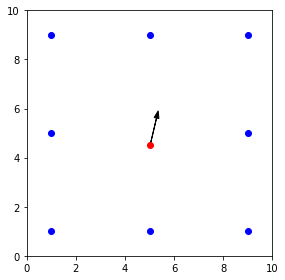

In [112]:
fig, ax = plt.subplots(1,1)
plt.plot(robot.lmks[:,0], robot.lmks[:,1], 'bo')
robot.plot_traj(fig, ax)

In [0]:
particles = [Robot(world_size=WORLD_SIZE) for i in range(NUM_PARTICLES)]
for particle in particles:
  particle.set_noise(sensor_noise=PARTICLE_SENSOR_NOISE,
                     forward_noise=PARTICLE_FWD_NOISE,
                     turn_noise=PARTICLE_TURN_NOISE)
  particle.move(angle=INIT_MOVE_ANGLE, fwd=INIT_MOVE_FWD)

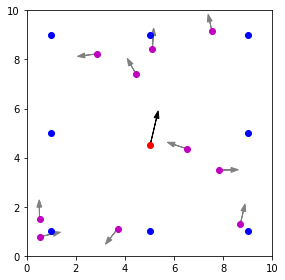

In [120]:
fig, ax = plt.subplots(1,1)
plt.plot(robot.lmks[:,0], robot.lmks[:,1], 'bo')
robot.plot_traj(fig, ax)
for particle in particles:
  particle.plot_traj(fig, ax, init_col='mo', arrow_col='grey')

In [118]:
[particle.measurement_prob(robot.sense()) for particle in particles]

[1.4411512353849538e-13,
 1.4138259313184563e-11,
 3.539914244050494e-11,
 1.0736892801945451e-10,
 5.446915752875693e-12,
 1.3847959911951956e-10,
 1.194853910511828e-10,
 2.040485337090033e-12,
 9.390216490159936e-15,
 7.635670359413245e-12]